In [1]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK


In [ ]:
# Define the area of interest (AOI) 
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-88.2, 43.0],  # Lower-left corner
            [-86.1, 43.0],  # Lower-right corner
            [-86.1, 45.0],  # Upper-right corner
            [-88.2, 45.0],  # Upper-left corner
            [-88.2, 43.0],  # Closing the polygon
        ]
    ],
}

#  time span of 3 months
time_of_interest = "2023-06-01/2023-09-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)
items = list(search.items())
print(f"Returned {len(items)} Items")


Returned 317 Items


In [4]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 6GB
Dimensions:      (y: 1938, x: 1937, time: 54)
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B01          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B02          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B03          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B04          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B05          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B12          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    B8A          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    SCL          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    WVP          (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>
    visual       (time, y, x) uint16 405MB dask.array<chunksize=(1, 1938, 1937), meta=np.ndarray>

In [5]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band


In [6]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Display the calculated NDCI
display(ndci)

<xarray.DataArray (time: 54, y: 1938, x: 1937)> Size: 811MB
dask.array<truediv, shape=(54, 1938, 1937), dtype=float32, chunksize=(1, 1938, 1937), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...

In [7]:
ndci = ndci.fillna(ndci.mean())

In [8]:
chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071
display(chl)

<xarray.DataArray (time: 54, y: 1938, x: 1937)> Size: 811MB
dask.array<add, shape=(54, 1938, 1937), dtype=float32, chunksize=(1, 1938, 1937), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 16kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 15kB 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 432B 2023-06-01T16:28:39.024000 ... 20...

In [9]:
# Select a subset of coordinates (first 50 coordinates)
chl_subset = chl[:, :50, :50]

In [10]:
print(chl_subset.shape)

(54, 50, 50)


In [11]:
# Define a function to prepare the time series data for LSTM
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (e.g., using last 5 values to predict the next)
time_steps = 10
#forecast_horizon = 5  # How many future timesteps to predict
X, y = create_dataset(chl_subset, time_steps)
print(f"X shape: {X.shape}, y shape: {y.shape}")



/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


X shape: (44, 10, 50, 50), y shape: (44, 50, 50)


In [12]:
print(X)

[[[[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   ...
   [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]]

  [[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403
     4.8387403]
   [ 5.096548   4.705545   4.833828  ...  4.579353   4.53042
     4.7270746]
   [ 4.7716393  4.8343954  4.8126745 ...  4.7151513  4.9156504
     4.709537 ]
   ...
   [ 5.7872276  5.0172014  5.9262066 ...  4.8411045  4.7376604
     4.8729815]
   [ 5.9522285  7.771146   6.269212  ...  4.740055   4.8182464
     4.7949038]
   [ 5.0487456  6.40352    6.0003576 ...  4.7421045  4.772131
     4.741048 ]]

  [[ 4.8387403  4.8387403  4.8387403 

In [13]:
print(y)

[[[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  ...
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  ...
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [10.881298   9.42156

In [14]:
# Reshape the input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], chl_subset.shape[1] * chl_subset.shape[2]))
y = np.reshape(y, (y.shape[0], chl_subset.shape[1] * chl_subset.shape[2]))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (44, 10, 2500), y shape: (44, 2500)


In [15]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (35, 10, 2500), y_train shape: (35, 2500)
X_test shape: (9, 10, 2500), y_test shape: (9, 2500)


In [16]:
from sklearn.preprocessing import MinMaxScaler
# Normalize input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Normalize target variable
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape back to the original shape
y_train_scaled = y_train_scaled.reshape(y_train.shape)  
y_test_scaled = y_test_scaled.reshape(y_test.shape) 

In [17]:
print(X_train_scaled.shape, y_train_scaled.shape)

(35, 10, 2500) (35, 2500)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(y.shape[1], activation='linear')
])
# Output a single value for each spatial location (the predicted next time point)
model.compile(optimizer='adam', loss='mean_squared_error')


# Print the model summary
model.summary()

/Users/aryamaniboruah/Desktop/Untitled/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │       510,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2500)           │       127,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,900 (2.51 MB)

 Trainable params: 657,900 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
print(X_train.shape)
print(y_train.shape)
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=32, validation_split=0.2)

(35, 10, 2500)
(35, 2500)
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0101 - val_loss: 0.0089
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0089 - val_loss: 0.0073
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0

In [36]:
# Evaluate the model
results = model.evaluate(X_test_scaled, y_test_scaled)
rmse = np.sqrt(results)
print(f"Model loss (MSE): {results}")
print("RMSE: ", rmse)

# Make predictions
predictions = model.predict(X_test_scaled)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0036
Model loss (MSE): 0.0035928082652390003
RMSE:  0.059940038915894944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.06475101 0.0660437  0.06482735 ... 0.08056407 0.07182383 0.05922201]
 [0.06077594 0.05882395 0.05910331 ... 0.07642645 0.06418824 0.05824773]
 [0.06329196 0.06263403 0.0623742  ... 0.07902533 0.06845218 0.05923809]
 ...
 [0.06428119 0.06693316 0.0658842  ... 0.08085671 0.07188246 0.05966645]
 [0.06102308 0.05841486 0.06128731 ... 0.07753037 0.06534838 0.05775528]
 [0.06356355 0.06338331 0.06262115 ... 0.07845053 0.06905749 0.0591794 ]]


In [21]:
print(predictions.shape)

(9, 2500)


In [22]:
print(y_test_scaled.min(), y_test_scaled.max())

0.015496343 4.1864614


In [23]:
print(predictions.min(), predictions.max())

0.0032667555 0.12569492


In [24]:
y_pred = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# Reshape the predictions back to the original shape
y_pred = y_pred.reshape(y_test.shape)

In [25]:
print(y_pred.min(), y_pred.max())

3.3339558 6.2595997


In [26]:
print(y_pred.shape)

(9, 2500)


In [27]:
print(y_pred)
print(y_test)

[[4.803234  4.834125  4.8050585 ... 5.181116  4.972252  4.6711087]
 [4.7082424 4.661596  4.668272  ... 5.0822396 4.7897854 4.647826 ]
 [4.7683673 4.7526445 4.746436  ... 5.144345  4.8916802 4.6714926]
 ...
 [4.792007  4.8553805 4.8303137 ... 5.188109  4.973653  4.6817293]
 [4.714148  4.65182   4.720463  ... 5.10862   4.817509  4.6360583]
 [4.7748575 4.7705503 4.752337  ... 5.130609  4.906145  4.67009  ]]
[[4.8387403 4.8387403 4.8387403 ... 5.8742237 5.8260927 5.8152647]
 [4.8387403 4.8387403 4.8387403 ... 4.8387403 4.8387403 4.8387403]
 [4.8387403 4.8387403 4.8387403 ... 4.95434   5.1065536 4.973926 ]
 ...
 [4.8387403 4.8387403 4.8387403 ... 4.8387403 4.8387403 4.8387403]
 [4.8387403 4.8387403 4.8387403 ... 4.8387403 4.8387403 4.8387403]
 [4.8387403 4.8387403 4.8387403 ... 5.016123  6.66735   7.1583033]]


In [ ]:
# import numpy as np

# # Save predictions as a Numpy .npy file
# np.save("predictions.npy", y_pred)
# np.save("y_test.npy", y_test)

In [28]:
# Reshape y_test_inverse back to its original shape
y_test_inverse = y_test.reshape((y_test.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_test_inverse)

[[[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 5.820029   5.6979504  5.715619  ...  5.7739954  5.732379   5.762457 ]
  [ 5.776979   5.7610188  5.689459  ...  5.7602816  5.759643   5.7371674]
  ...
  [ 5.670641   5.6122303  5.675846  ...  5.9106145  5.878869   5.9586477]
  [ 5.6001987  5.663886   5.6551514 ...  5.932478   5.854329   5.9143124]
  [ 5.641389   5.6626115  5.573516  ...  5.8742237  5.8260927  5.8152647]]

 [[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  ...
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]]

 [[ 4.8387403  4.8387403  4.8387403 ...  4.8387403  4.8387403  4.8387403]
  [ 6.792327   6.71015

In [29]:
print(y_test_inverse.shape)

(9, 50, 50)


In [30]:
# Reshape y_test_inverse back to its original shape
y_pred_inverse = y_pred.reshape((y_pred.shape[0], chl_subset.shape[1], chl_subset.shape[2]))
print(y_pred_inverse.shape)

(9, 50, 50)


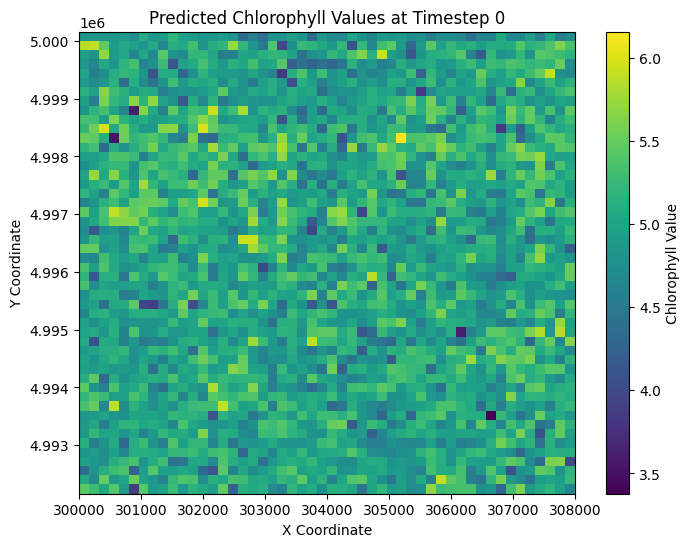

In [31]:
# Select a timestep to visualize (e.g., the first timestep in the test set)
timestep = 0

# Extract the data for the selected timestep
y_pred_timestep = y_pred_inverse[timestep]

# Extract the actual coordinates
x_coords = chl_subset.coords['x'].values
y_coords = chl_subset.coords['y'].values

# Create the visualization
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_coords, y_coords, y_pred_timestep, cmap='viridis', shading='auto')
plt.colorbar(label='Chlorophyll Value')
plt.title(f'Predicted Chlorophyll Values at Timestep {timestep}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

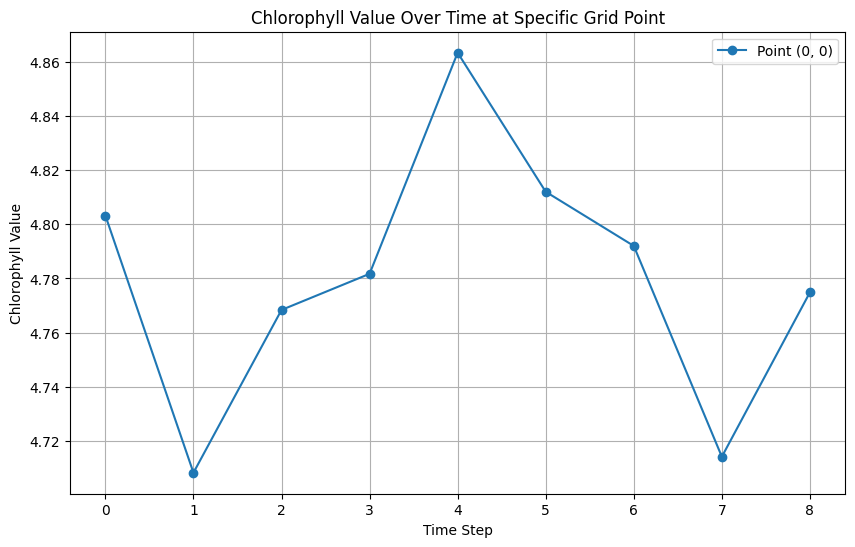

In [32]:
# Select a specific grid point (e.g., x_idx = 0, y_idx = 0 for top-left corner)
x_idx, y_idx = 0, 0

# Extract chlorophyll values over time for the specific point
time_series = y_pred_inverse[:, y_idx, x_idx]

# Plot chlorophyll values over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(time_series)), time_series, marker='o', linestyle='-', label=f'Point ({x_idx}, {y_idx})')
plt.title('Chlorophyll Value Over Time at Specific Grid Point')
plt.xlabel('Time Step')
plt.ylabel('Chlorophyll Value')
plt.grid()
plt.legend()
plt.show()


In [40]:
client.close()

In [42]:
model.save('LSTM_model.h5')
print("Model saved to LSTM_model.h5")

Model saved to LSTM_model.h5


In [43]:
# Save the current_input array to a .npy file
np.save('test_input.npy', X_test_scaled )
print("current_input saved to test_input.npy")

current_input saved to test_input.npy


In [44]:
# Save the y_train array to a .npy file
np.save('y_train.npy', y_train)
print("y_train saved to y_train.npy")

y_train saved to y_train.npy
